In [1]:
import os, sys, glob, re
import datetime
import numpy as np
from calendar import monthrange
import h5py

sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument/')
from concat_raw import get_num_days_pings, get_data_from_h5
from echogram_decomp import find_nearest_time_idx

/Users/wujung/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import matplotlib.pyplot as plt
import read_srad

# Set default colormap
plt.rcParams['image.cmap'] = 'jet'

In [3]:
from matplotlib.dates import date2num, num2date

In [4]:
%matplotlib inline

## Load echosounder data

In [6]:
pname = '/Volumes/wjlee_apl_3/ooi_zplsc_all_h5/'

In [7]:
yr = 2017
mn = 8
all_hr = range(24)  # list of all hour: 0-23
all_minutes = range(0,54,2)  # list of all minutes: 1-10
pings_per_day = len(all_hr)*len(all_minutes)
pings_per_hr = len(all_minutes)

In [31]:
def get_Sv_mtx(pname,YY,MM,DD,all_hr,all_minutes):
    # Get datetime object for all pings
    every_ping = [datetime.datetime(YY,MM,DD,hr,minutes,0) \
              for hr in all_hr for minutes in all_minutes]  # UTC time
    every_ping = [x+datetime.timedelta(seconds=7*60*60) for x in every_ping]  # adjust to local time
    
    # Open the first h5 file (due to UTC time shift)
    f = h5py.File(os.path.join(pname,'CE04OSPS_201708%02d.h5' % DD),'r')
    
    # Get f['data_times'] idx for every hour in all days in the month
    all_idx = [find_nearest_time_idx(f['data_times'],pp) for pp in every_ping]
    all_idx = np.array(all_idx)  # to allow numpy operation   

    # Extract timing and Sv data
    notnanidx = np.int_(all_idx[~np.isnan(all_idx)])  # all non-NaN index
    data_times = np.empty(all_idx.shape)  # initialize empty array
    data_times[~np.isnan(all_idx)] = f['data_times'][notnanidx.tolist()]
    Sv_mtx = np.empty((f['Sv'].shape[0],f['Sv'].shape[1],all_idx.shape[0]))
    Sv_mtx[:] = np.nan
    Sv_mtx[:,:,~np.isnan(all_idx)] = f['Sv'][:,:,notnanidx.tolist()]

    # Extract bin size
    bin_size = np.copy(f['bin_size'])
    f.close()

    # Open the second h5 file
    f = h5py.File(os.path.join(pname,'CE04OSPS_201708%02d.h5' % (DD+1)),'r')

    # Get f['data_times'] idx for every hour in all days in the month
    all_idx = [find_nearest_time_idx(f['data_times'],pp) for pp in every_ping]
    all_idx = np.array(all_idx)  # to allow numpy operation   

    # Extract timing and Sv data
    notnanidx = np.int_(all_idx[~np.isnan(all_idx)])  # all non-NaN index
    data_times[~np.isnan(all_idx)] = f['data_times'][notnanidx.tolist()]
    Sv_mtx[:,:,~np.isnan(all_idx)] = f['Sv'][:,:,notnanidx.tolist()]
    
    # Get depth bin_size
    bin_size = np.copy(f['bin_size'])
    
    f.close()
    
    return Sv_mtx,data_times,bin_size

In [32]:
(Sv_mtx_20,data_times_20,bin_size) = get_Sv_mtx(pname,yr,mn,20,all_hr,all_minutes)

In [34]:
(Sv_mtx_21,data_times_21,_) = get_Sv_mtx(pname,yr,mn,21,all_hr,all_minutes)

In [35]:
(Sv_mtx_22,data_times_22,_) = get_Sv_mtx(pname,yr,mn,22,all_hr,all_minutes)

## Load solar radiation data

In [36]:
srad_path = '/Volumes/wjlee_apl_3/ooi_eao_buoy/'
srad_file = 'eao_buoy_solar_radiation_20170831download.txt'

In [37]:
data = read_srad.read_srad_file(os.path.join(srad_path,srad_file))

In [38]:
all_minutes_rec = range(0,60,10)  # radiation comes every 10 mins
rec_per_day = len(all_hr)*len(all_minutes_rec)
rec_per_hr = len(all_minutes_rec)

In [39]:
def get_srad(data,YY,MM,DD,all_hr,all_minutes):
    # Get datetime object for all pings
    every_rec = [datetime.datetime(YY,MM,DD,hr,minutes,0) \
                  for hr in all_hr for minutes in all_minutes]  # UTC time
    every_rec = [x+datetime.timedelta(seconds=7*60*60) for x in every_rec]  # adjust to local time
    
    # Get timestamp for all radiation records
    rec_time = [datetime.datetime(y,m,d,h,mmin,0) for (y,m,d,h,mmin) in zip(data['#YY'],data['MM'],data['DD'],data['hh'],data['mm'])]
    rec_time_num = date2num(rec_time)
    
    # Return index of solar radiation time series
    return [np.argmin(np.abs(rec_time_num-date2num(x))) for x in every_rec]

In [40]:
idx_20 = get_srad(data,yr,mn,20,all_hr,all_minutes_rec)

In [41]:
idx_21 = get_srad(data,yr,mn,21,all_hr,all_minutes_rec)

In [42]:
idx_22 = get_srad(data,yr,mn,22,all_hr,all_minutes_rec)

## Plot

In [84]:
fig_path = '/Volumes/wjlee_apl_3/ooi_eclipse_eclipse/'

In [43]:
# Set xtick and labels
ping_idx = range(0,24*pings_per_hr,pings_per_hr)  # for echosounder
ping_labels = [str(x) for x in range(24)]
rec_idx = range(0,24*rec_per_hr,rec_per_hr)       # for solar radiation
rec_labels = [str(x) for x in range(24)]

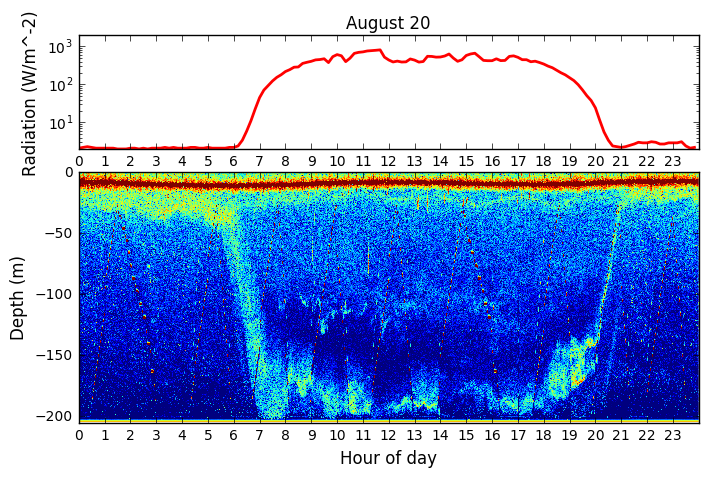

In [98]:
plt.figure(figsize=(8,5))
ax0 = plt.subplot2grid((3, 1), (0, 0))
ax1 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)

ax0.plot(data['SRAD1'][idx_20],'r',linewidth=2)
ax0.set_yscale('log')
ax0.set_xticks(rec_idx)
ax0.set_xticklabels(rec_labels)
ax0.set_xlim([0,24*rec_per_hr])
ax0.set_ylim([0,2E3])
ax0.set_yscale('log')
ax0.set_ylabel('Radiation (W/m^-2)',fontsize=12)
ax0.set_title('August 20')

ax1.imshow(Sv_mtx_20[2,:,:],aspect='auto',vmin=-80,vmax=-30,\
           interpolation='none',\
           extent=[0,24*pings_per_hr,-bin_size*Sv_mtx_20.shape[1],0])
ax1.set_xticks(ping_idx)
ax1.set_xticklabels(ping_labels)
ax1.set_ylabel('Depth (m)',fontsize=12)
plt.xlabel('Hour of day',fontsize=12)

plt.savefig(os.path.join(fig_path,'rad_echo_20170820.png'),dpi=120)

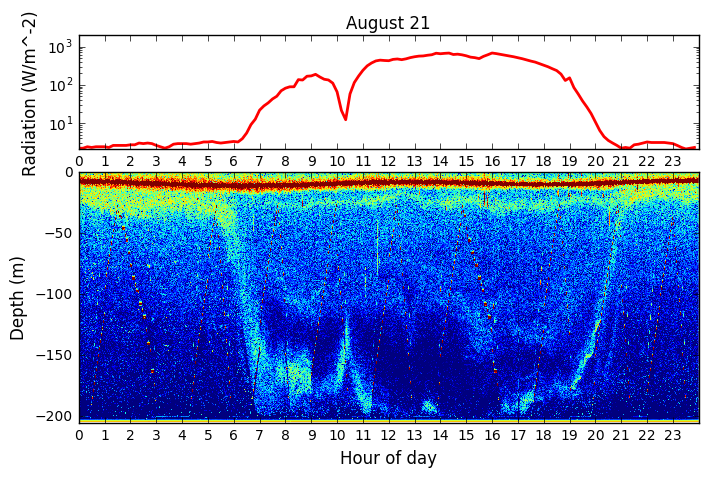

In [97]:
plt.figure(figsize=(8,5))
ax0 = plt.subplot2grid((3, 1), (0, 0))
ax1 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)

ax0.plot(data['SRAD1'][idx_21],'r',linewidth=2)
ax0.set_yscale('log')
ax0.set_xticks(rec_idx)
ax0.set_xticklabels(rec_labels)
ax0.set_xlim([0,24*rec_per_hr])
ax0.set_ylim([0,2E3])
ax0.set_yscale('log')
ax0.set_ylabel('Radiation (W/m^-2)',fontsize=12)
ax0.set_title('August 21')

ax1.imshow(Sv_mtx_21[2,:,:],aspect='auto',vmin=-80,vmax=-30,\
           interpolation='none',\
           extent=[0,24*pings_per_hr,-bin_size*Sv_mtx_20.shape[1],0])
ax1.set_xticks(ping_idx)
ax1.set_xticklabels(ping_labels)
ax1.set_ylabel('Depth (m)',fontsize=12)
plt.xlabel('Hour of day',fontsize=12)

plt.savefig(os.path.join(fig_path,'rad_echo_20170821.png'),dpi=120)

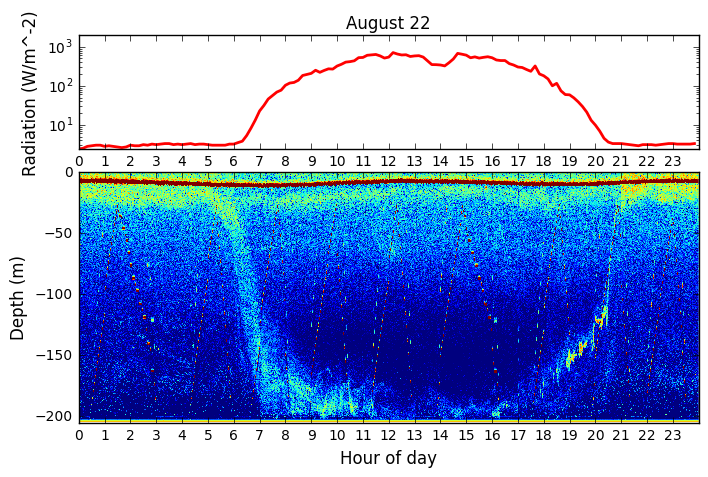

In [96]:
plt.figure(figsize=(8,5))
ax0 = plt.subplot2grid((3, 1), (0, 0))
ax1 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)

ax0.plot(data['SRAD1'][idx_22],'r',linewidth=2)
ax0.set_yscale('log')
ax0.set_xticks(rec_idx)
ax0.set_xticklabels(rec_labels)
ax0.set_xlim([0,24*rec_per_hr])
ax0.set_ylim([0,2E3])
ax0.set_yscale('log')
ax0.set_ylabel('Radiation (W/m^-2)',fontsize=12)
ax0.set_title('August 22')

ax1.imshow(Sv_mtx_22[2,:,:],aspect='auto',vmin=-80,vmax=-30,\
           interpolation='none',\
           extent=[0,24*pings_per_hr,-bin_size*Sv_mtx_20.shape[1],0])
ax1.set_xticks(ping_idx)
ax1.set_xticklabels(ping_labels)
ax1.set_ylabel('Depth (m)',fontsize=12)
plt.xlabel('Hour of day',fontsize=12)

plt.savefig(os.path.join(fig_path,'rad_echo_20170822.png'),dpi=120)